In [99]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # Set the seed
def bilinear_interpolation(grid_5km, output_shape):
    """
    Perform bilinear interpolation from a 5 km grid to a specified output grid size.

    Parameters:
    grid_5km (numpy.ndarray): 2D array with values at 5 km grid points.
    output_shape (tuple): The dimensions (height, width) of the output grid in terms of 1 km points.

    Returns:
    numpy.ndarray: A 2D array with the interpolated values at 1 km grid points.
    """
    input_height, input_width = grid_5km.shape
    output_height, output_width = output_shape

    # Calculate the scaling factors assuming the origin is the same
    scale_x = (input_width - 1) / (output_width - 1)
    scale_y = (input_height - 1) / (output_height - 1)

    # Prepare output grid
    grid_1km = np.zeros(output_shape)

    # Interpolate
    for i in range(output_height):
        for j in range(output_width):
            # Find the position in the original grid
            x = j * scale_x
            y = i * scale_y

            # Get integer and fractional parts
            x_int, y_int = int(x), int(y)
            x_frac, y_frac = x - x_int, y - y_int

            # Get values from the 5 km grid at corner points
            top_left = grid_5km[y_int, x_int]
            top_right = grid_5km[y_int, x_int + 1 if x_int + 1 < input_width else x_int]
            bottom_left = grid_5km[y_int + 1 if y_int + 1 < input_height else y_int, x_int]
            bottom_right = grid_5km[y_int + 1 if y_int + 1 < input_height else y_int, x_int + 1 if x_int + 1 < input_width else x_int]

            # Compute the interpolated value
            top = top_left + x_frac * (top_right - top_left)
            bottom = bottom_left + x_frac * (bottom_right - bottom_left)
            value = top + y_frac * (bottom - top)

            grid_1km[i, j] = value

    return grid_1km


In [108]:
# Example 5 km grid data (10x10 grid)
grid_5km = np.random.rand(10, 10)

# Target size: 50x50 grid of 1 km each (assuming 5 times finer resolution)
grid_1km = bilinear_interpolation(grid_5km, (50, 50))

print(grid_1km)


[[0.05168172 0.13978491 0.2278881  ... 0.46345207 0.36714216 0.27083225]
 [0.12281656 0.18257522 0.24233387 ... 0.41796194 0.34250624 0.26705053]
 [0.19395141 0.22536553 0.25677965 ... 0.37247182 0.31787032 0.26326882]
 ...
 [0.6700536  0.64193953 0.61382546 ... 0.76531225 0.76953219 0.77375213]
 [0.83027937 0.76315104 0.6960227  ... 0.75925315 0.76170033 0.7641475 ]
 [0.99050514 0.88436255 0.77821995 ... 0.75319405 0.75386846 0.75454287]]


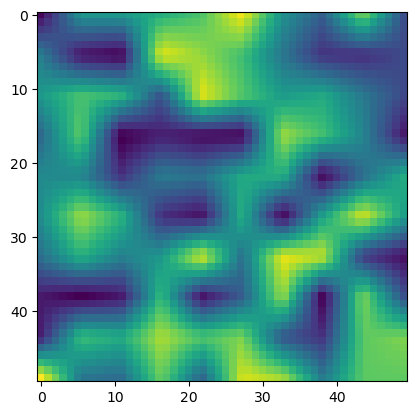

In [109]:
plt.imshow(grid_1km, cmap='viridis')

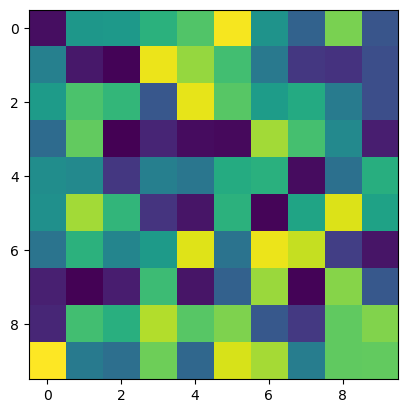

In [110]:
plt.imshow(grid_5km, cmap='viridis')

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

"""
Decorator for the function.
It Numba's jit decorator to compile the code into machine language for fast execution
which is useful for computationally intensive tasks like bilinear interpolation.
"""
@jit(nopython=True, fastmath=True, nogil=True, cache=True, parallel=True) 

def bilinear_interpolation(x_in, y_in, f_in, x_out, y_out):
    """
    Perform bilinear interpolation from a 5 km grid to a specified output grid size.
    Parameters:
    x_in (numpy.ndarray): 1D array with x-coordinates of the input grid.
    y_in (numpy.ndarray): 1D array with y-coordinates of the input grid.
    f_in (numpy.ndarray): 2D array with values at input grid points.
    x_out (numpy.ndarray): 1D array with x-coordinates of the output grid.
    y_out (numpy.ndarray): 1D array with y-coordinates of the output grid.

    Returns:
    numpy.ndarray: A 2D array with the interpolated values at output grid points.
    """
    f_out = np.zeros((y_out.size, x_out.size))
    # Loop over the output grid. Use prange for parallel execution.
    for i in prange(f_out.shape[1]):
        idx = np.searchsorted(x_in, x_out[i])
        
        # Find the x-coordinates of the bounding points
        x1 = x_in[idx-1]
        x2 = x_in[idx]
        x = x_out[i]
        
        # Loop over the y-coordinates
        for j in prange(f_out.shape[0]):
            idy = np.searchsorted(y_in, y_out[j])
            y1 = y_in[idy-1]
            y2 = y_in[idy]
            y = y_out[j]

            # Find the values at the four corners
            f11 = f_in[idy-1, idx-1]
            f21 = f_in[idy-1, idx]
            f12 = f_in[idy, idx-1]
            f22 = f_in[idy, idx]
            

            # Perform bilinear interpolation
            f_out[j, i] = ((f11 * (x2 - x) * (y2 - y) +
                            f21 * (x - x1) * (y2 - y) +
                            f12 * (x2 - x) * (y - y1) +
                            f22 * (x - x1) * (y - y1)) /
                           ((x2 - x1) * (y2 - y1)))
    
    return f_out

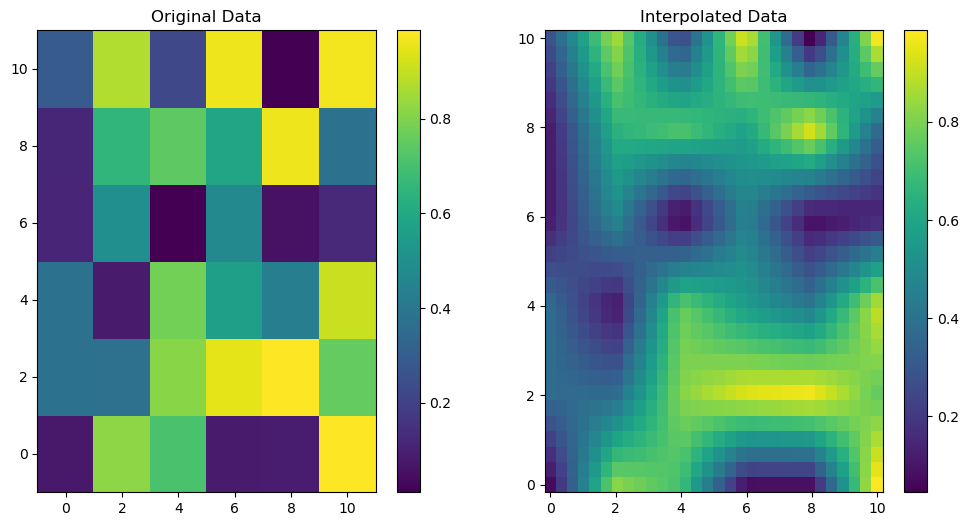

In [116]:
# Define input data grid
x_in = np.linspace(0, 10, 6)  # Input x-coordinates
y_in = np.linspace(0, 10, 6)  # Input y-coordinates
f_in = np.random.rand(6, 6)   # Random data values at each x_in, y_in coordinate

# Define output grid (where you want to interpolate)
x_out = np.linspace(0, 10, 30)  # Output x-coordinates
y_out = np.linspace(0, 10, 30)  # Output y-coordinates

# Perform bilinear interpolation
f_out = bilinear_interpolation(x_in, y_in, f_in, x_out, y_out)

# Visualizing the results using matplotlib
plt.figure(figsize=(12, 6))

# Plot original data as a mesh
plt.subplot(121)
plt.pcolor(x_in, y_in, f_in, shading='auto')
plt.title('Original Data')
plt.colorbar()

# Plot interpolated data as a mesh
plt.subplot(122)
plt.pcolor(x_out, y_out, f_out, shading='auto')
plt.title('Interpolated Data')
plt.colorbar()

plt.show()


In [114]:
f_in

array([[0.10312387, 0.90255291, 0.50525237, 0.82645747, 0.3200496 ,
        0.89552323],
       [0.38920168, 0.01083765, 0.90538198, 0.09128668, 0.31931364,
        0.95006197],
       [0.95060715, 0.57343789, 0.63183721, 0.44844552, 0.29321077,
        0.32866455],
       [0.67251846, 0.75237453, 0.79157904, 0.78961814, 0.0912061 ,
        0.4944203 ],
       [0.05755876, 0.54952888, 0.4415305 , 0.88770418, 0.35091501,
        0.11706702],
       [0.14299168, 0.76151063, 0.61821806, 0.10112268, 0.08410681,
        0.70096913]])